In [23]:
!pip install pyspark
!pip install geopandas
!pip install contextily

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [24]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import pandas as pd
import matplotlib.pyplot as plt
spark = SparkSession.builder.appName('DB_Final_Project').getOrCreate()

In [25]:
spark

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
taxi= spark.read\
      .option("header", "true")\
      .option("inferSchema", "true")\
      .parquet("/content/drive/MyDrive/yellow_tripdata_2022/yellow_tripdata_2022-01.parquet",
          "/content/drive/MyDrive/yellow_tripdata_2022/yellow_tripdata_2022-02.parquet",
          "/content/drive/MyDrive/yellow_tripdata_2022/yellow_tripdata_2022-03.parquet",
          "/content/drive/MyDrive/yellow_tripdata_2022/yellow_tripdata_2022-04.parquet",
          "/content/drive/MyDrive/yellow_tripdata_2022/yellow_tripdata_2022-05.parquet",
          "/content/drive/MyDrive/yellow_tripdata_2022/yellow_tripdata_2022-06.parquet",
          "/content/drive/MyDrive/yellow_tripdata_2022/yellow_tripdata_2022-07.parquet",
          "/content/drive/MyDrive/yellow_tripdata_2022/yellow_tripdata_2022-08.parquet",
          "/content/drive/MyDrive/yellow_tripdata_2022/yellow_tripdata_2022-09.parquet",
          "/content/drive/MyDrive/yellow_tripdata_2022/yellow_tripdata_2022-10.parquet",
          "/content/drive/MyDrive/yellow_tripdata_2022/yellow_tripdata_2022-11.parquet",
          "/content/drive/MyDrive/yellow_tripdata_2022/yellow_tripdata_2022-12.parquet")

In [28]:
#taxi.printSchema()

In [29]:
#taxi.count()

In [30]:
taxi=taxi.na.drop(how="any")

In [31]:
#filter->select * where...
taxi=taxi.filter(year(col("tpep_pickup_datetime"))=="2022")

In [32]:
taxi=taxi.distinct()

In [33]:
#sort->order by
taxi.sort("tpep_pickup_datetime").show(5)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       2| 2022-01-01 00:00:08|  2022-01-01 00:14:14|            1.0|         7.94|       1.0|                 N|         138|         255|           1|       23.0|  0.5|    0.5|      4.8

In [34]:
#date can be changed here
date="2022-"+input("What date do you want to know? enter in type mm-dd: ")
pickup_by_day=taxi.filter(col("tpep_pickup_datetime").startswith(date))
#pickup_by_day.show(5)

What date do you want to know? enter in type mm-dd: 04-25
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       2| 2022-04-25 00:01:54|  2022-04-25 00:06:40|            1.0|         0.92|       1.0|                 N|          24|   

In [35]:
#alias->name as
pbd_hour=pickup_by_day.select(hour(col("tpep_pickup_datetime")).alias("hour")).groupby("hour").count()
            

In [36]:
#pbd_hour.show(24)

+----+-----+
|hour|count|
+----+-----+
|  12| 6080|
|  22| 4370|
|   1|  684|
|  13| 6233|
|   6| 2068|
+----+-----+
only showing top 5 rows



In [37]:
#change from pyspark dataframe to pandas dataframe
pbd_hour_pd=pbd_hour.sort("hour").toPandas()

Most pickup hour:  18, having  7952  pickup counts.
Least pickup hour:  3, having   222  pickup counts.


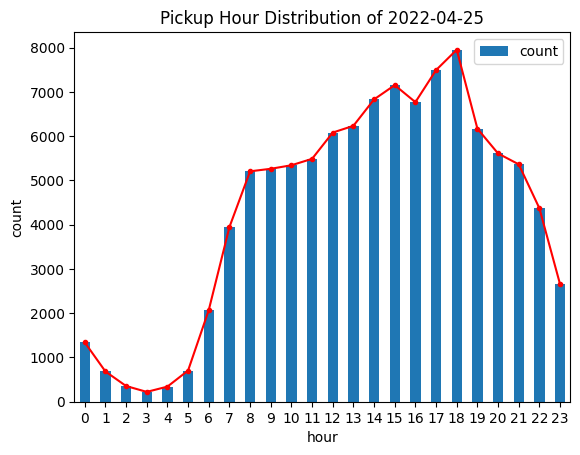

In [38]:
print("Most pickup hour: {:3d}, having {:5d}  pickup counts."
    .format(pbd_hour_pd['hour'].loc[pbd_hour_pd['count'].idxmax()],pbd_hour_pd["count"].max()))
print("Least pickup hour: {:2d}, having {:5d}  pickup counts."
    .format(pbd_hour_pd['hour'].loc[pbd_hour_pd['count'].idxmin()],pbd_hour_pd["count"].min()))
#pbd_hour_pd=pbd_hour_pd
pbd_hour_pd.plot.bar(x='hour', y='count')
plt.plot(pbd_hour_pd["hour"],pbd_hour_pd["count"],color="r",marker=".")
plt.title(f"Pickup Hour Distribution of {date}")
plt.xlabel("hour")
plt.ylabel("count")
plt.xticks(rotation=0)
plt.show()

In [39]:
#read location map data
import geopandas as gpd
shapefile_path = "/content/drive/MyDrive/yellow_tripdata_2022/taxi_zones.zip"  # Replace with the actual path to the shapefile directory

gdf = gpd.read_file(shapefile_path)


In [40]:
#gdf

In [41]:
pbd_location=pickup_by_day.select(col("PULocationID").alias("LocationID")).groupBy("LocationID").count()
#pbd_location.sort("LocationID").show(5)

In [42]:
pbd_location_pd=pbd_location.toPandas()

In [43]:
#left join gdf and pbd_location_pd
gdf_location = gdf.merge(pbd_location_pd, on='LocationID', suffixes=('', '_count'),how="left")
gdf_location['count'] = gdf_location['count'].fillna(0)

Most pickup zone:  JFK Airport  in  Queens  borough, having 6294.0  pickup location.


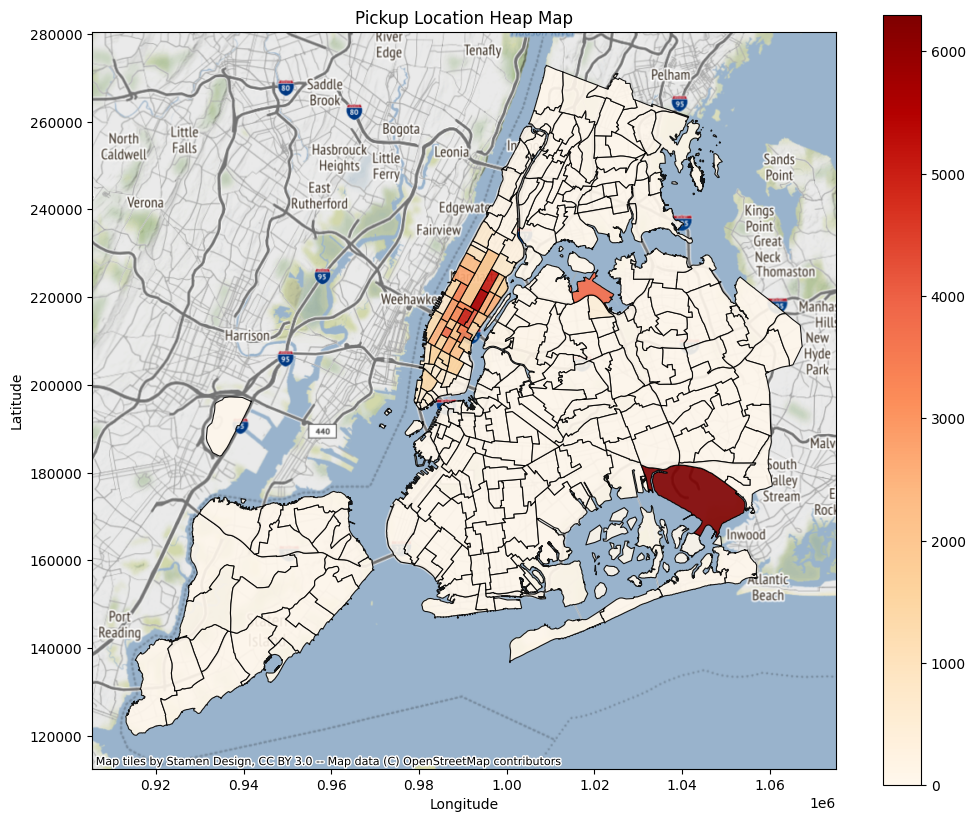

In [44]:
print("Most pickup zone: ",gdf_location['zone'].loc[gdf_location['count'].idxmax()],
      " in ",gdf_location['borough'].loc[gdf_location['count'].idxmax()],
      f" borough, having {gdf_location['count'].max()}  pickup location.")
import contextily as cx
fig, ax = plt.subplots(figsize=(12, 10))
#plot heap map of pickups
gdf_location.plot(column='count', cmap='OrRd', linewidth=0.8, 
        ax=ax, edgecolor='k', alpha=0.9,legend=True)
#add NYC borough as basemap 
cx.add_basemap(ax,crs=gdf_location.crs)
ax.set_title('Pickup Location Heap Map')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()

Most dropoff zone:  Upper East Side North  in  Manhattan  borough, having 5295.0  dropoff counts.


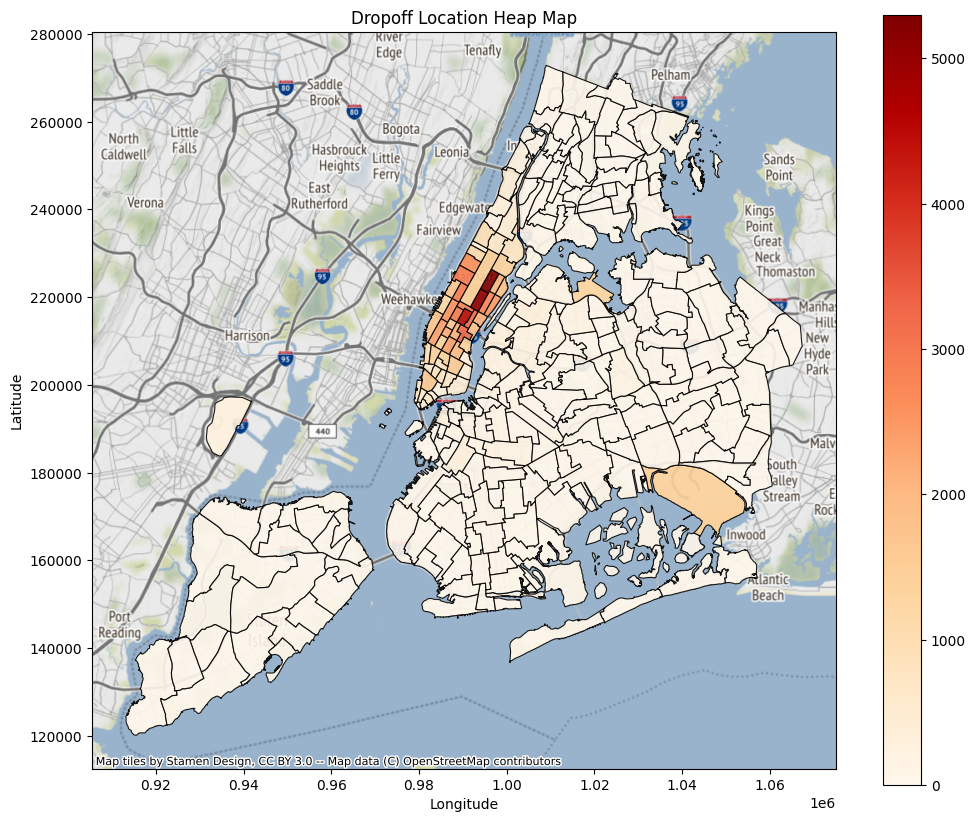

In [57]:
pbd_dolocation=pickup_by_day.select(col("DOLocationID").alias("LocationID")).groupBy("LocationID").count()
pbd_dolocation_pd=pbd_dolocation.toPandas()
gdf_docounts = gdf.merge(pbd_dolocation_pd, on='LocationID', suffixes=('', '_count'),how="left")
gdf_docounts['count'] = gdf_docounts['count'].fillna(0)
print("Most dropoff zone: ",gdf_docounts['zone'].loc[gdf_docounts['count'].idxmax()],
      " in ",gdf_docounts['borough'].loc[gdf_docounts['count'].idxmax()],
      f" borough, having {gdf_docounts['count'].max()}  dropoff counts.")

fig, ax = plt.subplots(figsize=(12, 10))
gdf_docounts.plot(column='count', cmap='OrRd', linewidth=0.8, 
        ax=ax, edgecolor='k', alpha=0.9,legend=True)

cx.add_basemap(ax,crs=gdf_docounts.crs)
ax.set_title('Dropoff Location Heap Map')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()